# Correlação entre internações por SRAG e variações climáticas na região metropolitana do Rio de Janeiro no período pré-covid (2013-2018)
#####TCC para obtenção do título de especialista em Data Science e Analytics pela Universidade de São Paulo - USP/ESALQ

## I) Instalação e importação de pacotes

##### Instalação de pacotes Python

In [ ]:
!pip install unidecode

##### Carregamento de pacotes

In [106]:
#sistema
import warnings
warnings.filterwarnings('ignore')
import os
import re
import requests

#etl e data wrangling
import zipfile
import numpy as np
import pandas as pd
from unidecode import unidecode

#analytics
import statsmodels.api as sm
from scipy.stats import zscore, kurtosis, shapiro
from sklearn.neighbors import KNeighborsClassifier

#dataviz
import matplotlib.pyplot as plt
import seaborn as sns


## II) Criação de funções para uso geral

##III) ETL e Data Wrangling

### Base de dados bruta

In [4]:
#obtendo a base de dados completa
path = f'/content/drive/MyDrive/sivep/sivep_gripe_'

anos = range(2013, 2019)

df_sivep_raw = pd.DataFrame()
for ano in anos:
  df_aux = pd.read_csv(path + str(ano) + '.csv', sep=';', encoding='latin-1')
  df_sivep_raw = pd.concat([df_sivep_raw, df_aux], axis=0)

df_sivep_raw.head()

,Número da notificação,Data da notificação,Semana epidemiológica da notificação,Data dos primeiros sintomas,Semana epidemiológica dos primeiros sintomas,UF notificante,Município notificante,Código do município notificante,Unidade notificante,CNES da unidade notificante,...,Classificação final - completo,Agente etiológico,Critério do encerramento,Evolução do caso,Data da alta ou óbito,Semana epidemiológica da alta ou óbito,Data do encerramento,Observações,Data da digitação no sistema,Data da base de dados
0,I333019,17/07/2014,201429,12/07/2013,201328,RJ,RIO DE JANEIRO,330455,SES RJ HOSPITAL ESTADUAL CARLOS CHAGAS,2273411.0,...,SRAG por outro vírus respiratório,Outros agentes etiológicos,1 - Laboratorial,1 - Cura,29/07/2014,201431.0,05/08/2014,NaN,NaN,NaN
1,I325003,27/11/2013,201348,18/11/2013,201347,RJ,RIO DE JANEIRO,330455,IFF FIOCRUZ,2708353.0,...,SRAG não especificado,Outros agentes etiológicos,3 - Clínico,1 - Cura,04/12/2013,201349.0,30/07/2014,NaN,NaN,NaN
2,I322770,01/07/2014,201427,20/11/2013,201347,RJ,RIO DE JANEIRO,330455,SAMCI HOSPITAL INFANTIL,3067556.0,...,SRAG não especificado,Outros agentes etiológicos,1 - Laboratorial,1 - Cura,27/11/2013,201348.0,01/07/2014,NaN,NaN,NaN
3,I321488,23/12/2013,201352,14/12/2013,201350,RJ,RIO DE JANEIRO,330455,HOSPITAL ESPANHOL,2298759.0,...,SRAG não especificado,Outros agentes etiológicos,1 - Laboratorial,1 - Cura,25/12/2013,201352.0,26/12/2013,NaN,NaN,NaN
4,I320087,03/06/2014,201423,05/12/2013,201349,RJ,RIO DE JANEIRO,330455,UERJ HOSPITAL UNIV PEDRO ERNESTO,2269783.0,...,SRAG por influenza,Influenza A e B,1 - Laboratorial,1 - Cura,12/12/2013,201350.0,03/06/2014,NaN,NaN,NaN


In [5]:
df_sivep_raw.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Index: 7950 entries, 0 to 1992
Data columns (total 180 columns):
 #    Column                                                         Non-Null Count  Dtype  
---   ------                                                         --------------  -----  
 0    Número da notificação                                          7950 non-null   object 
 1    Data da notificação                                            7950 non-null   object 
 2    Semana epidemiológica da notificação                           7950 non-null   int64  
 3    Data dos primeiros sintomas                                    7950 non-null   object 
 4    Semana epidemiológica dos primeiros sintomas                   7950 non-null   int64  
 5    UF notificante                                                 7950 non-null   object 
 6    Município notificante                                          7950 non-null   object 
 7    Código do município notificante                       

### Separando as colunas de interesse da pesquisa e renomeando para facilitar o tratamento dos dados

In [6]:
df_sivep = df_sivep_raw[[
    'Código do município de residência',
    'Data da notificação',
    'Data dos primeiros sintomas',
    'Município notificante',
    'Sexo',
    'Data de nascimento',
    'Gestante',
    'Raça/cor',
    'Escolaridade',
    'Município de residência',
    'Houve internação para SRAG',
    'Data de internação',
    'Data de saída da internação',
    'Município de internação']]

df_sivep = df_sivep.rename(columns={
    'Código do município de residência': 'id_municipio',
    'Data da notificação': 'dt_ref',
    'Data dos primeiros sintomas': 'pc_dt_sintomas',
    'Município notificante': 'us_municipio',
    'Sexo': 'pc_sexo',
    'Data de nascimento': 'pc_dt_nascimento',
    'Gestante': 'pc_gravidez',
    'Raça/cor': 'pc_cor',
    'Escolaridade': 'pc_escolaridade',
    'Município de residência': 'pc_municipio',
    'Houve internação para SRAG': 'pc_internacao',
    'Data de internação': 'pc_dt_internacao',
    'Data de saída da internação': 'pc_dt_alta',
    'Município de internação': 'pc_municipio_internacao'
})


In [7]:
df_sivep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7950 entries, 0 to 1992
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id_municipio             7943 non-null   float64
 1   dt_ref                   7950 non-null   object 
 2   pc_dt_sintomas           7950 non-null   object 
 3   us_municipio             7950 non-null   object 
 4   pc_sexo                  7950 non-null   object 
 5   pc_dt_nascimento         7878 non-null   object 
 6   pc_gravidez              7938 non-null   object 
 7   pc_cor                   7038 non-null   object 
 8   pc_escolaridade          7363 non-null   object 
 9   pc_municipio             7943 non-null   object 
 10  pc_internacao            7888 non-null   object 
 11  pc_dt_internacao         7715 non-null   object 
 12  pc_dt_alta               7729 non-null   object 
 13  pc_municipio_internacao  7780 non-null   object 
dtypes: float64(1), object(13)
mem

### Tratamento das variáveis quali

In [8]:
df_sivep['pc_sexo'].unique()
df_sivep['pc_sexo'] = df_sivep['pc_sexo'].map({
    '1 - Masculino': 'm',
    '2 - Feminino': 'f',
    '9 - Ignorado': 'ignorado'
})

In [9]:
df_sivep['pc_gravidez'].unique()

def is_pregnant(text):
    if not isinstance(text, str):
        return 0
    return 0 if re.search(r'\b6\b|\b9\b', text) else 1 #6 e 9 são os itens não gestação

df_sivep['pc_gravidez'] = df_sivep['pc_gravidez'].apply(is_pregnant)

In [10]:
df_sivep['pc_cor'].unique()
df_sivep['pc_cor'] = df_sivep['pc_cor'].map({
    '2 - Preta': 'preta',
    '1 - Branca': 'branca',
    '4 - Parda': 'parda',
    '9 - Ignorado': 'ignorada',
    '5 - Indígena': 'indigena',
    '3 - Amarela': 'amarela'
}).fillna('ingorada')

In [11]:
df_sivep['pc_escolaridade'].unique()
df_sivep['pc_escolaridade'] = df_sivep['pc_escolaridade'].map({
    '5 - Não se aplica': 'ignorado',
    '9 - Ignorado': 'ignorado',
    '6 - Fundamental 1ª a 9ª série': 'basico',
    '3 - Médio': 'medio',
    '4 - Superior': 'superior',
    '0 - Sem escolaridade/analfabeto': 'sem_escolaridade'
}).fillna('ignorado')

In [12]:
df_sivep['pc_internacao'].unique()
df_sivep['pc_internacao'] = df_sivep['pc_internacao'].map({
    '1 - Sim': 1,
    '2 - Não': 0,
    '9 - Ignorado': 0
})

### Tratamento de datas

In [13]:
def date_handling(df, column_name):
  df[column_name] = df[column_name].astype('string').str.replace('/', '-')
  df[column_name] = pd.to_datetime(df[column_name], format='mixed')

  return df

for column in ['dt_ref', 'pc_dt_sintomas', 'pc_dt_nascimento', 'pc_dt_internacao', 'pc_dt_alta']:
  df_sivep = date_handling(df_sivep, column)

### Tratamento da idade dos pacientes

In [14]:
df_sivep['pc_idade'] = (df_sivep['dt_ref'] - df_sivep['pc_dt_nascimento']).dt.days // 365

In [15]:
df_sivep['pc_idade'] = np.ceil(df_sivep['pc_idade']/5)

In [16]:
df_sivep['pc_idade'] = df_sivep['pc_idade'].map({
    0: '0 a 4 anos',
    1: '5 a 9 anos',
    2: '10 a 14 anos',
    3: '15 a 19 anos',
    4: '20 a 24 anos',
    5: '25 a 29 anos',
    6: '30 a 34 anos',
    7: '35 a 39 anos',
    8: '40 a 44 anos',
    9: '45 a 49 anos',
    10: '50 a 54 anos',
    11: '55 a 59 anos',
    12: '60 a 64 anos',
    13: '65 a 69 anos',
    14: '70 a 74 anos',
    15: '75 a 79 anos',
    16: '80 a 84 anos',
    17: '85 a 89 anos',
    18: '90 a 94 anos',
    19: '95 a 99 anos',
    20: '100 anos ou mais'
})

### Consolidando a base de dados

In [17]:
df_sivep_final = df_sivep.groupby([
    'id_municipio', 'dt_ref', 'pc_dt_sintomas', 'us_municipio', 'pc_sexo', 'pc_dt_nascimento',
    'pc_gravidez', 'pc_cor', 'pc_escolaridade', 'pc_municipio',
    'pc_dt_internacao', 'pc_dt_alta', 'pc_municipio_internacao'
])['pc_internacao'].sum().reset_index()

In [18]:
df_sivep_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7420 entries, 0 to 7419
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   id_municipio             7420 non-null   float64       
 1   dt_ref                   7420 non-null   datetime64[ns]
 2   pc_dt_sintomas           7420 non-null   datetime64[ns]
 3   us_municipio             7420 non-null   object        
 4   pc_sexo                  7420 non-null   object        
 5   pc_dt_nascimento         7420 non-null   datetime64[ns]
 6   pc_gravidez              7420 non-null   int64         
 7   pc_cor                   7420 non-null   object        
 8   pc_escolaridade          7420 non-null   object        
 9   pc_municipio             7420 non-null   object        
 10  pc_dt_internacao         7420 non-null   datetime64[ns]
 11  pc_dt_alta               7420 non-null   datetime64[ns]
 12  pc_municipio_internacao  7420 non-

## 2) Obtendo e tratando a base de dados de população estimada da região metropolitana do RJ

In [19]:
df_pop = pd.read_csv('/content/drive/MyDrive/populacao_residente_estimada_2013_2018.csv', sep=',')
df_pop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102 entries, 0 to 101
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   county_id             102 non-null    int64 
 1   county                102 non-null    object
 2   estimated_population  102 non-null    int64 
 3   year                  102 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 3.3+ KB


### Tratando os nomes das colunas

In [20]:
df_pop = df_pop.rename(columns={
    'county_id': 'id_municipio',
    'county': 'municipio',
    'estimated_population': 'populacao_estimada',
    'year': 'ano'
})

In [21]:
df_aux_pop = df_pop.copy()
df_aux_pop['ano'] = df_aux_pop['ano'].fillna(2018).astype('int64')
df_aux_pop = df_aux_pop.pivot_table(index='municipio', columns='ano', values='populacao_estimada')
df_aux_pop.index.name = None
df_aux_pop.columns.name = None
df_aux_pop

,2013,2014,2015,2016,2017,2018
BELFORD ROXO,477583,479386,481127,494141,495783,508614
DUQUE DE CAXIAS,873921,878402,882729,886917,890997,914383
ITABORAI,225263,227168,229007,230786,232394,238695
ITAGUAI,115542,117374,119143,120855,122369,125913
JAPERI,98393,99141,99863,100562,101237,103960
MAGE,232419,233634,234809,236319,237420,243657
MARICA,139552,143111,146549,149876,153008,157789
MESQUITA,170185,170473,170751,171020,171280,175620
NILOPOLIS,158288,158299,158309,158319,158329,162269
NITEROI,494200,495470,496696,497883,499028,511786


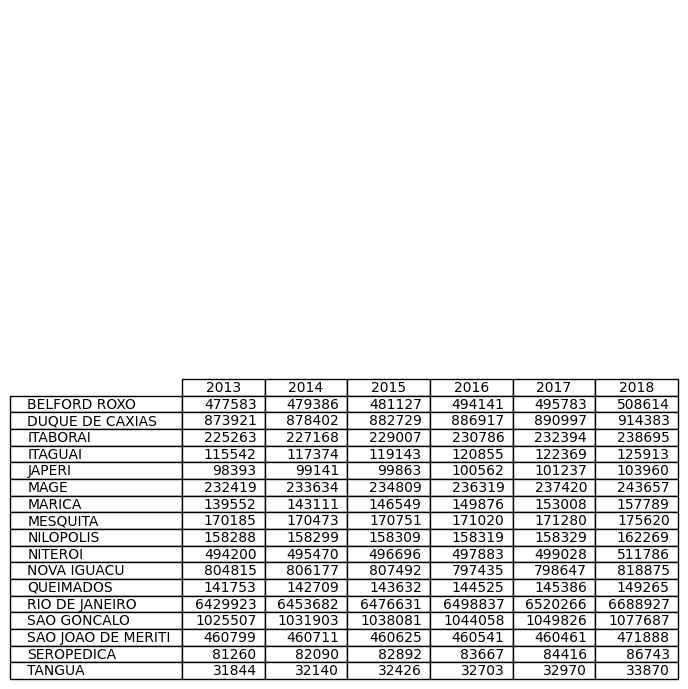

In [22]:
TableExport(df_aux_pop, 'populacao_estimada_por_municipio')

### Criando uma lista única de códigos de município para filtrar a base do sistema de saúde

In [23]:
municipios = df_pop['id_municipio'].unique()
municipios

array([330045, 330170, 330190, 330200, 330227, 330250, 330270, 330285,
       330320, 330330, 330350, 330414, 330455, 330490, 330510, 330555,
       330575])


## 3) Obtendo a base de dados do clima

In [24]:
+
#path = f'/content/drive/MyDrive/inmet clima/'
years = range(2013, 2019)

df_clima = pd.DataFrame()

#for year in years:
#  with zipfile.ZipFile(path + str(year) + '.zip', 'r') as zip_ref:
#    zip_ref.extractall('/content/drive/MyDrive/inmet clima/unziped')

path2 = '/content/drive/MyDrive/inmet clima/unziped/'
for year in years:
  path_final = path2 + str(year)
  for arquivo in os.listdir(path_final):
    if arquivo.startswith('INMET_SE_RJ'):
      station = pd.read_csv(os.path.join(path_final, arquivo), encoding='utf-8', encoding_errors='ignore', nrows=6, sep=';')
      station_uf = station.iloc[0, 1]
      station_name = station.iloc[1, 1]
      station_latitude = station.iloc[3, 1] #+ station.iloc[3, 2]/100000000
      station_longitude = station.iloc[4, 1] #+ station.iloc[4, 2]/100000000
      df_aux = pd.read_csv(os.path.join(path_final, arquivo), encoding='utf-8', encoding_errors='ignore', skiprows=8, sep=';')
      df_aux.insert(0, 'station_uf', station_uf)
      df_aux.insert(1, 'station_name', station_name)
      df_aux.insert(2, 'latitude', station_latitude)
      df_aux.insert(3, 'longitude', station_longitude)

      df_clima = pd.concat([df_clima, df_aux], axis=0)
    else:
      pass

df_clima.head()

SyntaxError: invalid syntax (<ipython-input-24-ab516c6d078b>, line 1)

In [ ]:
#df_clima.to_csv('/content/drive/MyDrive/inmet clima/raw_weather_database_rj.csv', sep=';')

In [ ]:
sorted(df_clima['station_name'].unique())

In [ ]:
df_clima = df_clima.loc[~df_clima['station_name'].isna()]
df_clima.info()

In [ ]:
df_clima = df_clima.rename(columns={
    'DATA (YYYY-MM-DD)': 'date_ref',
    'PRECIPITAO TOTAL, HORRIO (mm)': 'precipitacao_total',
    'UMIDADE RELATIVA DO AR, HORARIA (%)': 'umidade_relativa_do_ar',
    'VENTO, VELOCIDADE HORARIA (m/s)': 'velocidade_do_vento',
    'TEMPERATURA DO AR - BULBO SECO, HORARIA (C)': 'temperatura_bulbo_seco',
    'TEMPERATURA DO PONTO DE ORVALHO (C)': 'temperatura_ponto_orvalho',
    'RADIACAO GLOBAL (KJ/m)': 'radiacao_solar'
})
df_clima.head()

In [ ]:
for column in df_clima.columns[6:]:
  try:
    df_clima[column] = df_clima[column].str.replace(',', '.')
  except AttributeError:
    pass

  df_clima[column] = df_clima[column].astype('float64').fillna(0)

df_clima.head()

In [ ]:
### cálculos das variáveis a serem consideradas no modelo
df_clima['amplitude_termica_bulbo_seco'] = \
  df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['temperatura_bulbo_seco'].transform('max') - \
  df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['temperatura_bulbo_seco'].transform('min')

df_clima['amplitude_termica_orvalho'] = \
  df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['temperatura_ponto_orvalho'].transform('max') - \
  df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['temperatura_ponto_orvalho'].transform('min')

df_clima['max_umidade'] = df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['umidade_relativa_do_ar'].transform('max')
df_clima['min_umidade'] = df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['umidade_relativa_do_ar'].transform('min')

df_clima['max_radiacao'] = df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['radiacao_solar'].transform('max')

df_clima['max_vento'] = df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['velocidade_do_vento'].transform('max')

df_clima['max_temperatura_seco'] = df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['temperatura_bulbo_seco'].transform('max')
df_clima['min_temperatura_seco'] = df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['temperatura_bulbo_seco'].transform('min')

df_clima['max_temperatura_orvalho'] = df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['temperatura_ponto_orvalho'].transform('max')
df_clima['min_temperatura_orvalho'] = df_clima.groupby(['date_ref', 'station_name', 'latitude', 'longitude'])['temperatura_ponto_orvalho'].transform('min')

df_clima.head()

In [ ]:
df_clima = df_clima[[
    'date_ref',
    'latitude',
    'longitude',
    'station_name',
    'max_temperatura_seco',
    'min_temperatura_seco',
    'max_temperatura_orvalho',
    'min_temperatura_orvalho',
    'amplitude_termica_bulbo_seco',
    'amplitude_termica_orvalho',
    'max_umidade',
    'min_umidade',
    'max_radiacao',
    'max_vento'
    ]]

df_clima = df_clima.drop_duplicates()
df_clima.head()

In [25]:
#df_clima.to_csv('/content/drive/MyDrive/inmet clima/treated_weather_db_rj.csv', sep=';')
df_clima = pd.read_csv('/content/drive/MyDrive/inmet clima/treated_weather_db_rj.csv', sep=';')

In [26]:
df_sivep_final['pc_municipio_internacao'].unique()

array(['VASSOURAS', 'PETROPOLIS', 'NILOPOLIS', 'RIO DE JANEIRO',
       'NITEROI', 'VALENCA', 'MACAE', 'RESENDE', 'ITAPERUNA',
       'ANGRA DOS REIS', 'VOLTA REDONDA', 'ITAGUAI',
       'CAMPOS DOS GOYTACAZES', 'PARATY', 'ARARUAMA', 'SAQUAREMA',
       'TRES RIOS', 'ARMACAO DOS BUZIOS', 'BARRA DO PIRAI', 'SAO PAULO',
       'MARILIA', 'BARRA MANSA', 'MURIAE', 'DUQUE DE CAXIAS',
       'NOVA IGUACU', 'NOVA FRIBURGO', 'BOM JARDIM',
       'BOM JESUS DO ITABAPOANA', 'CABO FRIO', 'SAO GONCALO',
       'RIO DAS OSTRAS', 'ITABORAI', 'CAMBUCI', 'QUISSAMA', 'CANTAGALO',
       'ALEM PARAIBA', 'CARMO', 'CASIMIRO DE ABREU',
       'CONCEICAO DE MACABU', 'MAGE', 'SAO JOAO DE MERITI', 'TERESOPOLIS',
       'GUAPIMIRIM', 'IGUABA GRANDE', 'RIO BONITO', 'ITAOCARA', 'MARICA',
       'MESQUITA', 'LONDRINA', 'CAMPINAS', 'ARACAJU', 'BARBACENA',
       'QUEIMADOS', 'VALINHOS', 'PARAIBA DO SUL', 'PINHEIRAL', 'PIRAI',
       'PORTO REAL', 'RIO CLARO', 'RIO DAS FLORES', 'ITATIBA',
       'JOINVILLE', 'GUARU

In [27]:
### conectando a base do IBGE para pegar as coordenadas geográficas dos municípios
url = 'https://servicodados.ibge.gov.br/api/v1/localidades/estados/33/distritos'
response = requests.get(url)

if response.status_code == 200:
  print('Requisição bem sucedida!')
  df_aux = response.json()

else:
  print('Erro na requisição:', response.status_code)

municipios = pd.DataFrame(df_aux)
municipios.head()

Requisição bem sucedida!


,id,nome,municipio
0,330010005,Angra dos Reis,"{'id': 3300100, 'nome': 'Angra dos Reis', 'mic..."
1,330010010,Abraão,"{'id': 3300100, 'nome': 'Angra dos Reis', 'mic..."
2,330010015,Cunhambebe,"{'id': 3300100, 'nome': 'Angra dos Reis', 'mic..."
3,330010025,Mambucaba,"{'id': 3300100, 'nome': 'Angra dos Reis', 'mic..."
4,330015905,Aperibé,"{'id': 3300159, 'nome': 'Aperibé', 'microrregi..."


In [28]:
def tratar_strings(texto):
    return str.upper(unidecode(texto))

municipios['nome'] = municipios['nome'].apply(tratar_strings)

In [29]:
municipios = municipios.loc[municipios['nome'].isin(df_sivep_final['pc_municipio_internacao'].unique())]

In [30]:
municipios['id_aux'] = municipios['municipio'].apply(lambda x: x['id'])
municipios = municipios[['id', 'id_aux', 'nome']]
municipios.head()

,id,id_aux,nome
0,330010005,3300100,ANGRA DOS REIS
5,330020905,3300209,ARARUAMA
11,330023305,3300233,ARMACAO DOS BUZIOS
13,330030805,3300308,BARRA DO PIRAI
19,330040705,3300407,BARRA MANSA


In [31]:
df_coords = pd.DataFrame()

for id in municipios['id_aux'].unique():
  url2 = f'https://servicodados.ibge.gov.br/api/v3/malhas/municipios/{id}/metadados' ### a região do município é mandatória

  response2 = requests.get(url2)
  aux = response2.json()

  df_aux = pd.DataFrame({
      'id_aux': [id],
      'longitude': [aux[0]['centroide'].get('longitude')],
      'latitude': [aux[0]['centroide'].get('latitude')]
  })

  df_coords = pd.concat([df_coords, df_aux], axis=0)

df_coords.head()

,id_aux,longitude,latitude
0,3300100,-44.3856,-22.9364
0,3300209,-42.2929,-22.7553
0,3300233,-41.9507,-22.7764
0,3300308,-43.9130,-22.4257
0,3300407,-44.1883,-22.5058


In [32]:
municipios = municipios.merge(df_coords, how='left', on='id_aux')
municipios.head()

,id,id_aux,nome,longitude,latitude
0,330010005,3300100,ANGRA DOS REIS,-44.3856,-22.9364
1,330020905,3300209,ARARUAMA,-42.2929,-22.7553
2,330023305,3300233,ARMACAO DOS BUZIOS,-41.9507,-22.7764
3,330030805,3300308,BARRA DO PIRAI,-43.9130,-22.4257
4,330040705,3300407,BARRA MANSA,-44.1883,-22.5058


In [33]:
### Cluesterizando os municipios
aux = municipios.copy()
aux = aux.loc[aux['nome'].isin(df_aux_pop.index)]

estacoes = df_clima[['station_name', 'longitude', 'latitude']].drop_duplicates()
estacoes = estacoes.rename(columns={'station_name': 'nome'})
estacoes['nome'] = 'EA_' + estacoes['nome']
estacoes.insert(0, 'id', None)
estacoes.insert(1, 'id_aux', None)
estacoes['latitude'] = estacoes['latitude'].str.replace(',', '.').astype('float64')
estacoes['longitude'] = estacoes['longitude'].str.replace(',', '.').astype('float64')
estacoes = estacoes.drop_duplicates()

aux = pd.concat([aux, estacoes], axis=0)
aux = aux.loc[~(aux['latitude'].isna()) & ~(aux['longitude'].isna())]

n_clusters = 8

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(aux[['longitude', 'latitude']])

aux['cluster'] = kmeans.labels_

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


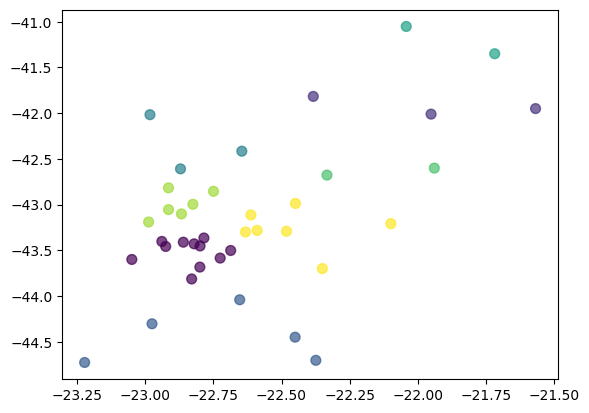

In [34]:
plt.scatter(aux.latitude, aux.longitude, c=kmeans.labels_, s=50, alpha=0.7)

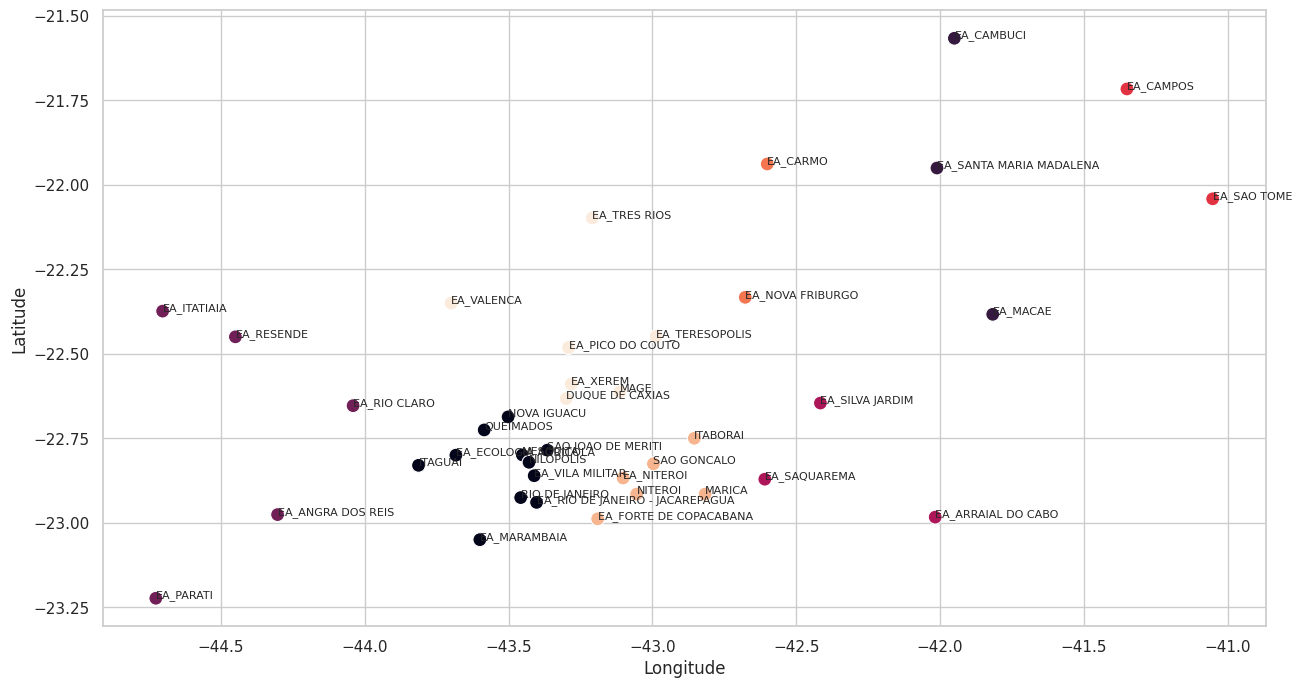

In [35]:
sns.set(style="whitegrid")
plt.figure(figsize=(15, 8))


sns.scatterplot(data=aux, x='longitude', y='latitude', c=aux['cluster'], s=100)

for index, row in aux.iterrows():
    plt.text(row['longitude'], row['latitude'], row['nome'], fontsize=8)

plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.savefig('cluster_de_municipios.jpeg')

In [36]:
estacoes_aux = estacoes[['nome', 'latitude', 'longitude']]
estacoes_aux



,nome,latitude,longitude
0,EA_ECOLOGIA AGRICOLA,-22.800000,-43.683333
365,EA_MARAMBAIA,-23.050000,-43.600000
730,EA_XEREM,-22.589722,-43.282222
1095,EA_CAMBUCI,-21.566667,-41.950000
1460,EA_ARRAIAL DO CABO,-22.983333,-42.016667
1825,EA_CAMPOS,-21.716667,-41.350000
2190,EA_MACAE,-22.383333,-41.816667
2555,EA_RESENDE,-22.450000,-44.450000
2920,EA_PICO DO COUTO,-22.481667,-43.291389
3285,EA_VALENCA,-22.350000,-43.700000


In [58]:
aux = aux.loc[~aux['nome'].str.contains('EC_')]
X_municipios = aux[['latitude', 'longitude']]
X_estacoes = estacoes_aux[['latitude', 'longitude']]

knn = KNeighborsClassifier(n_neighbors=1)

knn.fit(X_estacoes, estacoes_aux['nome'])

estacoes_mais_proximas = knn.predict(X_municipios)

aux['estacao_mais_proxima'] = estacoes_mais_proximas
aux['estacao_mais_proxima'] = aux['estacao_mais_proxima'].str.replace('EA_', '')

In [59]:
aux

,id,id_aux,nome,longitude,latitude,cluster,estacao_mais_proxima
14,330170205,3301702,DUQUE DE CAXIAS,-43.299600,-22.632500,7,XEREM
17,330190005,3301900,ITABORAI,-42.854300,-22.750000,6,SAQUAREMA
18,330200705,3302007,ITAGUAI,-43.813300,-22.830100,0,ECOLOGIA AGRICOLA
22,330250205,3302502,MAGE,-43.113000,-22.612600,7,XEREM
23,330270005,3302700,MARICA,-42.816800,-22.915200,6,SAQUAREMA
24,330285805,3302858,MESQUITA,-43.452300,-22.799300,0,VILA MILITAR
25,330320305,3303203,NILOPOLIS,-43.429000,-22.821100,0,VILA MILITAR
26,330330205,3303302,NITEROI,-43.054700,-22.915100,6,NITEROI
28,330350005,3303500,NOVA IGUACU,-43.501800,-22.686800,0,VILA MILITAR
35,330414405,3304144,QUEIMADOS,-43.584900,-22.725400,0,ECOLOGIA AGRICOLA


In [60]:
aux.to_csv('/content/drive/MyDrive/inmet clima/municipios_com_estacoes_proximas.csv', sep=';')

In [111]:
#df_clima['year'] = pd.to_datetime(df_clima['date_ref']).dt.strftime('%Y')
df_map = {i: j for i, j in zip(aux['nome'], aux['estacao_mais_proxima'])}

TypeError: 'module' object is not callable

{<pandas.core.strings.accessor.StringMethods object at 0x7bdd97363700>: <pandas.core.strings.accessor.StringMethods object at 0x7bdd97362f50>}


In [95]:
df_sivep_final.head()

,id_municipio,dt_ref,pc_dt_sintomas,us_municipio,pc_sexo,pc_dt_nascimento,pc_gravidez,pc_cor,pc_escolaridade,pc_municipio,pc_dt_internacao,pc_dt_alta,pc_municipio_internacao,pc_internacao
0,140010.0,2018-11-05,2018-08-05,VASSOURAS,m,2018-02-16,0,branca,ignorado,BOA VISTA,2018-10-05,2018-05-21,VASSOURAS,1.0
1,150680.0,2016-05-23,2016-07-05,PETROPOLIS,m,1966-05-28,0,ignorada,ignorado,SANTAREM,2016-12-05,2016-05-13,PETROPOLIS,1.0
2,240830.0,2016-05-26,2016-05-26,NILOPOLIS,m,1960-05-25,0,ignorada,superior,NOVA CRUZ,2016-05-27,2016-07-06,NILOPOLIS,1.0
3,250750.0,2013-07-27,2013-07-25,RIO DE JANEIRO,f,1992-04-15,0,parda,ignorado,JOAO PESSOA,2013-07-26,2013-07-28,RIO DE JANEIRO,1.0
4,292740.0,2018-11-05,2018-07-05,NITEROI,f,2016-02-16,0,branca,ignorado,SALVADOR,2018-10-05,2018-05-15,NITEROI,1.0


In [87]:
df_clima.head()

,Unnamed: 0,date_ref,latitude,longitude,station_name,max_temperatura_seco,min_temperatura_seco,max_temperatura_orvalho,min_temperatura_orvalho,amplitude_termica_bulbo_seco,amplitude_termica_orvalho,max_umidade,min_umidade,max_radiacao,max_vento,month_ref,year
0,0,2013-01-01,"-22,8","-43,68333333",ECOLOGIA AGRICOLA,36.0,24.4,24.4,20.4,11.6,4.0,97.0,43.0,3412.1,5.5,2013,2013
1,24,2013-01-02,"-22,8","-43,68333333",ECOLOGIA AGRICOLA,30.9,23.7,24.4,20.5,7.2,3.9,95.0,54.0,2185.3,9.2,2013,2013
2,48,2013-01-03,"-22,8","-43,68333333",ECOLOGIA AGRICOLA,24.5,23.0,23.9,22.6,1.5,1.3,100.0,96.0,444.4,4.3,2013,2013
3,72,2013-01-04,"-22,8","-43,68333333",ECOLOGIA AGRICOLA,27.4,23.2,23.8,23.1,4.2,0.7,99.0,78.0,1899.7,3.3,2013,2013
4,96,2013-01-05,"-22,8","-43,68333333",ECOLOGIA AGRICOLA,32.5,22.6,25.4,22.0,9.9,3.4,100.0,60.0,3273.4,5.8,2013,2013


In [94]:
df_clima.iloc[:, 5:] = df_clima.iloc[:, 5:].astype('float64')
df_clima = df_clima.loc[(df_clima.iloc[:, 5:] > 0).all(axis=1)]

aux_clima = df_clima.copy()
aux_clima = aux_clima[['year', 'max_temperatura_seco', 'min_temperatura_seco', 'max_vento', 'max_umidade', 'min_umidade', 'amplitude_termica_bulbo_seco', 'max_radiacao']]

aux_clima = aux_clima.groupby('year').mean().reset_index()
aux_clima

,year,max_temperatura_seco,min_temperatura_seco,max_vento,max_umidade,min_umidade,amplitude_termica_bulbo_seco,max_radiacao
0,2013.0,26.244326,18.268027,4.697875,93.268691,59.909108,7.976300,2654.110361
1,2014.0,27.541188,18.556009,4.922163,92.158279,54.143280,8.985179,2959.263963
2,2015.0,27.834073,19.247753,4.695093,92.751914,56.655152,8.586320,2760.601845
3,2016.0,27.573089,18.782864,4.486095,92.374521,56.185845,8.790225,2668.812440
4,2017.0,27.237426,18.377933,4.436159,91.914210,54.939121,8.859493,2738.635083
5,2018.0,27.154098,18.725410,3.996363,92.632941,57.723873,8.428689,2632.506865


0        36.0
1        30.9
2        24.5
3        27.4
4        32.5
         ... 
41190    27.8
41191    29.4
41192    29.9
41193    29.8
41194    30.2
Name: max_temperatura_seco, Length: 40065, dtype: float64

## 4) Verificando se existe sazonalidade nos dados de internações por SRAG

### Reduzindo a dimensionalidade da base de dados

###### Reduzindo ainda mais a base de dados para conter apenas os dados de internações

In [ ]:
df_sazo = df_sivep_final.copy()
df_sazo = df_sazo.loc[(df_sazo['id_municipio']).isin(municipios)]
df_sazo = df_sazo.groupby(['dt_ref'])['pc_internacao'].sum(numeric_only=True).reset_index()
df_sazo.head()

###### Garantindo que existirão todas as datas

In [ ]:
dates = pd.date_range('2013-01-01', '2018-12-31', freq='d')

df_aux = pd.DataFrame({'dt_ref': dates})

In [ ]:
df_aux = df_aux.merge(df_sazo, how='left', on='dt_ref').fillna(0)

In [ ]:
df_aux.head()

### Sazonalidade mensal

In [ ]:
df_monthly = df_aux.copy()
df_monthly['dt_ref'] = pd.to_datetime(df_monthly['dt_ref']).dt.strftime('%Y-%m')
df_monthly = df_monthly.groupby('dt_ref')['pc_internacao'].sum().reset_index()

df_monthly.head()

In [ ]:
mean = df_monthly['pc_internacao'].mean()
std = df_monthly['pc_internacao'].std()
std1 = mean + std
std2 = mean + std * 2
std3 = mean + std * 3

In [ ]:
plt.figure(figsize=[12, 7])
sns.lineplot(x='dt_ref', y='pc_internacao', data=df_monthly, label='Internações')
plt.xlabel('Mês')
plt.ylabel('Internações')
plt.tick_params(axis='x', labelrotation=90)
plt.axhline(y=mean, color='red', linestyle='--', label='Média')
plt.axhline(y=std1, color='gray', linestyle='--')
plt.axhline(y=std2, color='gray', linestyle='--')
plt.axhline(y=std3, color='gray', linestyle='--')
plt.annotate('1 Desvio Padrão', xy=(0.2, std1), xytext=(0.2, std1 + 0.1),
             ha='left', va='bottom')
plt.annotate('2 Desvios Padrão', xy=(0.2, std2), xytext=(0.2, std2 + 0.1),
             ha='left', va='bottom')
plt.annotate('3 Desvios Padrão', xy=(0.2, std3), xytext=(0.2, std3 + 0.1),
             ha='left', va='bottom')
plt.legend()
#plt.savefig('internacoes_por_mes.jpeg')

In [ ]:
### Verificando se o ano de 2016 é um outlier
df_year = df_monthly.copy()
df_year['dt_ref'] = pd.to_datetime(df_year['dt_ref']).dt.strftime('%Y')
df_year = df_year.groupby('dt_ref')['pc_internacao'].sum().reset_index()
df_year

In [ ]:
z_scores = zscore(df_year['pc_internacao'])

In [ ]:
df_year = df_year.rename(columns={'dt_ref': 'Ano', 'pc_internacao': 'Internações'})
df_year['z-score'] = z_scores
df_year = df_year.set_index('Ano')
df_year['z-score'] = round(df_year['z-score'], 4)

In [ ]:
df_year.to_csv('base_internacoes_zscore.csv')
z_scores

In [ ]:
TableExport(df_year, 'internacoes_ano_com_zscore')

#### Removendo o ano de 2016 da base para analisar sazonalidades

In [ ]:
df_monthly = df_monthly.loc[
    (pd.to_datetime(df_monthly['dt_ref']).dt.strftime('%Y') != '2016')
]

In [ ]:
### Teste estatístico de estacionaridade
results = sm.tsa.adfuller(df_monthly['pc_internacao'])
print(
    f'ADF Statistic: {results[0]}\n'
    f'p-value: {results[1]}'
)

In [ ]:
aux = pd.DataFrame({'ADF Statistic': [round(results[0], 4)], 'p-value': [round(results[1], 4)]})
TableExport(aux, 'teste_adf')

In [ ]:
### Análise de autocorrelação
plt.figure(figsize=(12, 7))
sm.tsa.graphics.plot_acf(df_monthly['pc_internacao'], lags=24, title='')
plt.xlabel('Lags')
plt.savefig('teste_acf_internacoes.jpeg')

In [ ]:
### decomposição sazonal com 12 períodos
decompose = sm.tsa.seasonal_decompose(
    df_monthly['pc_internacao'],
    model='add',
    period=12,
    two_sided=True,
    extrapolate_trend=True,
)

In [ ]:
decompose.resid.sum()

In [ ]:
### teste de ljung-box para verificar a correlação dos resíduos
results = sm.stats.acorr_ljungbox(decompose.resid, lags=30)
p_value = results.iloc[:, 1]
p_value

In [ ]:
df_seasonal = pd.DataFrame({
    'dt_ref': df_monthly['dt_ref'],
    'cases': df_monthly['pc_internacao'],
    'seasonal': decompose.seasonal,
    'trend': decompose.trend,
    'residual': decompose.resid
})

#df_seasonal['date_ref'] = pd.to_datetime(df_seasonal['date_ref']).dt

fig, axes = plt.subplots(4, 1, figsize=(12, 7))

ax0 = plt.subplot2grid((4, 1), (0, 0), rowspan=1)
sns.lineplot(x='dt_ref', y='cases', data=df_seasonal)
ax0.set_title('Cases')
plt.tick_params(axis='x', labelrotation=90)

ax1 = plt.subplot2grid((4, 1), (1, 0), rowspan=1)
sns.lineplot(x='dt_ref', y='trend', data=df_seasonal)
ax1.set_title('Trend')
plt.tick_params(axis='x', labelrotation=90)

ax2 = plt.subplot2grid((4, 1), (2, 0), rowspan=1)
sns.lineplot(x='dt_ref', y='seasonal', data=df_seasonal)
ax2.set_title('Seasonality')
plt.tick_params(axis='x', labelrotation=90)

ax3 = plt.subplot2grid((4, 1), (3, 0), rowspan=1)
sns.lineplot(x='dt_ref', y='residual', data=df_seasonal)
ax3.set_title('Residual')
plt.tick_params(axis='x', labelrotation=90)

plt.tight_layout()
plt.savefig('seasonal_decompose.jpeg')

In [ ]:
sup = df_seasonal['residual'].mean()+16.42
inf = df_seasonal['residual'].mean()-16.42
df_seasonal.loc[(df_seasonal['residual']>=inf) & (df_seasonal['residual']<=sup)].count() / df_seasonal['residual'].count()

In [ ]:
kurtosis(df_seasonal['residual'])

In [ ]:
1-0.7686036061632158

In [ ]:
sns.boxplot(df_seasonal['residual'])